In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

In [17]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)

In [18]:
cate_col = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cate_col:
    df[col] = le.fit_transform(df[col].astype(str))

In [19]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [20]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

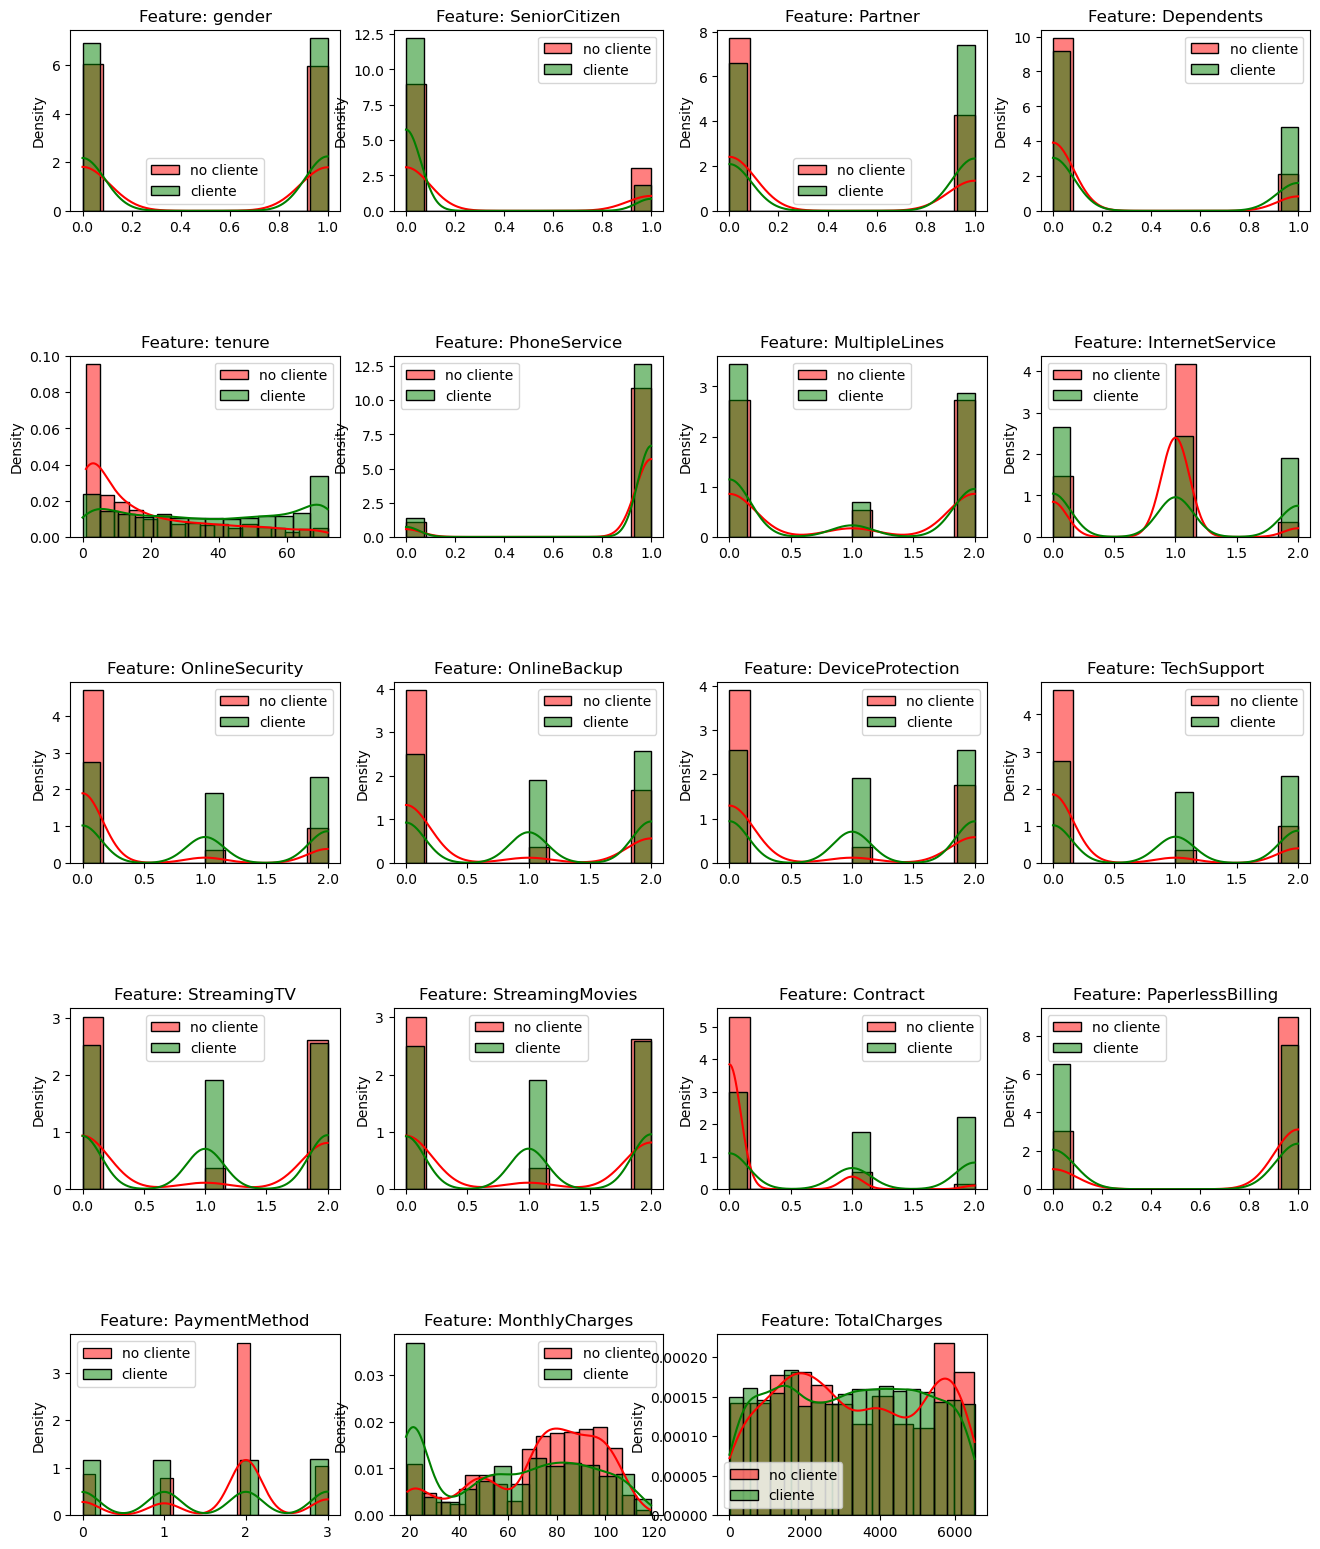

In [21]:
plt.figure(figsize=(16,32))
gs = gs.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(X):
    ax = plt.subplot(gs[i])
    sns.histplot(data=df[df['Churn'] == 1], x=f, kde=True, color='red', stat='density', label='no cliente', alpha=0.5)
    sns.histplot(data=df[df['Churn'] == 0], x=f, kde=True, color='green', stat='density', label='cliente', alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f'Feature: {f}')
    ax.legend()
plt.show()    
    

In [22]:
seed = 60
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed, stratify=y)

In [23]:
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [24]:
neg, pos  = np.bincount(y_train)
scale_pos_weight = neg / pos

In [25]:
alg = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=seed)
alg.fit(X_train_resampled, y_train_resampled, eval_set=[(X_test, y_test)], verbose=False)

/opt/anaconda3/envs/computervision_face_recognition/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:23:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
y_probs = alg.predict_proba(X_test)[:, 1]

In [27]:
np.random.seed(seed)
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Mejor threshold basado en F1-score: {best_threshold:.3f}")


Mejor threshold basado en F1-score: 0.527


In [28]:
y_pred = (y_probs >= best_threshold).astype(int)
print(f'Reporte de clasificación: (threshold={best_threshold:.3f})')
print(classification_report(y_test, y_pred))

Reporte de clasificación: (threshold=0.527)
              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1035
           1       0.57      0.75      0.65       374

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.75      1409
weighted avg       0.81      0.78      0.79      1409



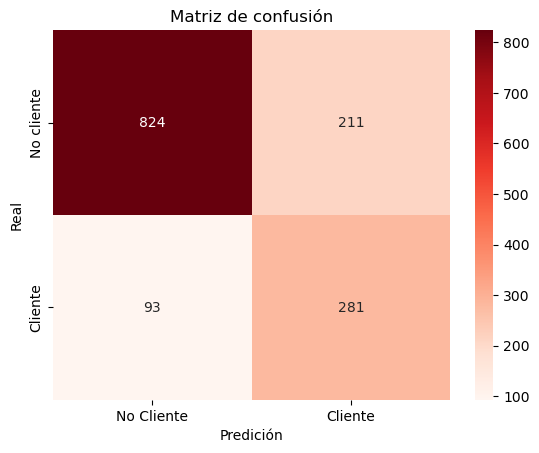

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["No Cliente", "Cliente"], yticklabels=["No cliente", "Cliente"])
plt.xlabel("Predición")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

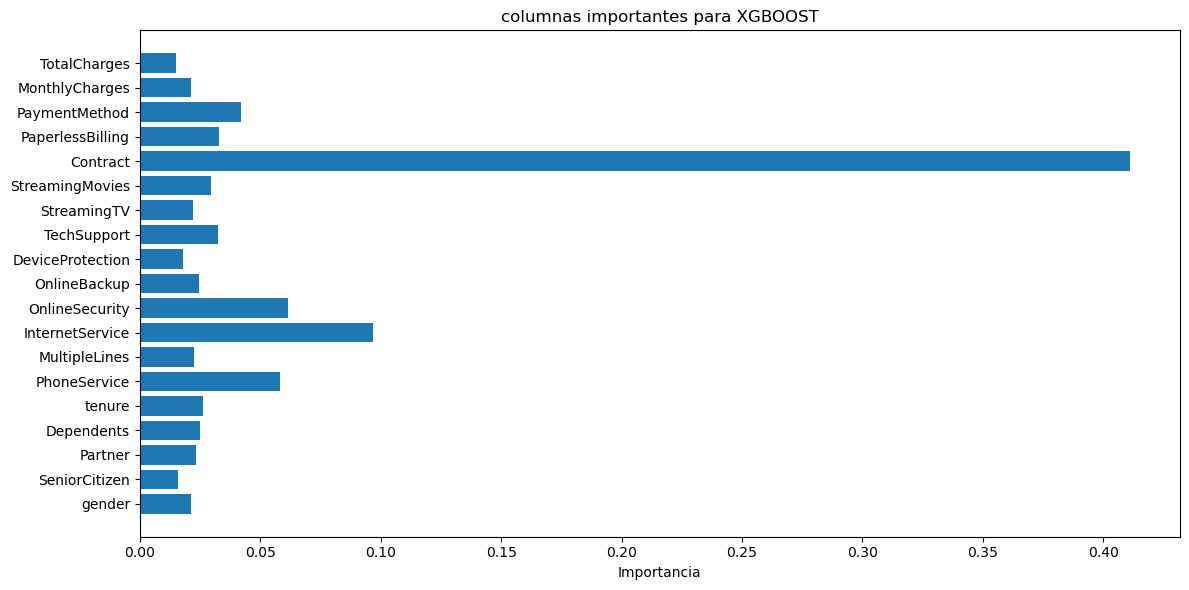

In [30]:
importancias_a = alg.feature_importances_
features = X.columns

plt.figure(figsize=(12, 6))
plt.barh(features, importancias_a)
plt.title('columnas importantes para XGBOOST')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()
